<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicting the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: June 30, 2022

---

# Data Transformation

#### Table of Contents:
* [Exploratory Data Analysis](#eda)
* [Data Transformation](#transform)
    * [Non-Numeric to Numeric](#numcols)
    * [Null Values and Duplicates](#nulldupe)
* Feature Engineering
    * [New Feature: Major Label](#majorlab)
    * [New Feature: Genre](#genre)

---

### Exploratory Data Analysis<a class="anchor" id="eda"></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# display all the columns
pd.set_option('display.max_columns', None)

In [2]:
# import the raw merged dataset
songs_df = pd.read_csv('capstone_dataset_raw.csv', encoding='Latin1')

In [3]:
dupe_by_trackuri = songs_df.duplicated(subset=['track_uri']).sum()

print(f'Number of rows: {songs_df.shape[0]}')
print(f'Number of columns: {songs_df.shape[1]}')
print(f'Null Values: {songs_df.isna().sum().sum()}')
print(f'Duplicate Values: {dupe_by_trackuri}')

Number of rows: 13807
Number of columns: 30
Null Values: 51
Duplicate Values: 35


There are 51 null values and 35 duplicates (by `track_uri`) in this dataset. We will need to address this during the data transformation phase. 

Next, let's check the data types of our columns

In [4]:
songs_df.dtypes

billboard             int64
billboard_year       object
billboard_date       object
peak_position        object
weeks_on_chart       object
artist               object
feat_artist          object
artist_uri           object
artist_popularity    object
artist_followers     object
artist_genre         object
song                 object
track_uri            object
track_popularity     object
album_name           object
release_date         object
release_year          int64
duration_ms          object
danceability         object
energy               object
key                  object
loudness             object
mode                 object
speechiness          object
acousticness         object
instrumentalness     object
liveness             object
valence              object
tempo                object
time_signature       object
dtype: object

All the columns except `billboard` and `release_year` are in a string format.  We will need to convert the data type for some of these columns.

Now let's check the class balance in our target variable (billboard).

In [5]:
bb_df = songs_df[songs_df['billboard'] == 1]
nonbb_df = songs_df[(songs_df['billboard'] == 0)]
print(f'Number of Billboard Songs: {bb_df.shape[0]}')
print(f'Number of Non-Billboard Songs: {nonbb_df.shape[0]}')

Number of Billboard Songs: 6819
Number of Non-Billboard Songs: 6988


Looks good! Each class represents almost 50% of the data. 

Let's look at the distribution of songs per `release_year`. The reason why it is important to look at this metric is that music is an ever-evolving trend and we want to ensure that each period is represented fairly. Let's look at Class 1 (bb_df) first.

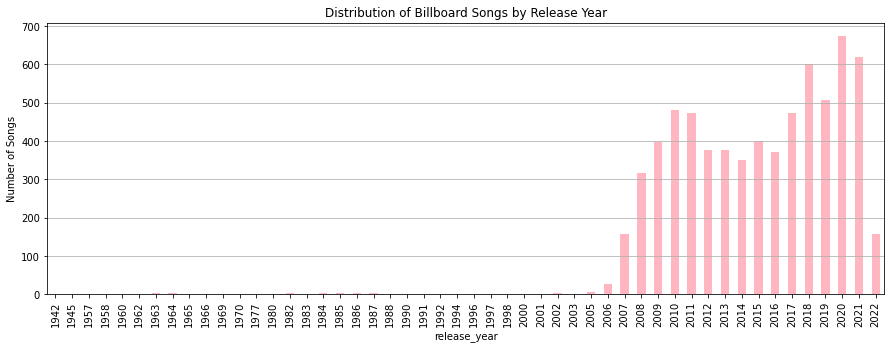

In [6]:
# look at the distribution by billboard_year
bb_df.sort_values('release_year').groupby('release_year')['release_year'].count().plot(kind='bar',
                                                                                       figsize=(15,5),
                                                                                       title='Distribution of Billboard Songs by Release Year',
                                                                                       color='lightpink')
plt.grid(axis='y')
plt.ylabel('Number of Songs')
plt.xticks(rotation='vertical')
plt.show()

It looks like we have songs dating all the way back to 1942! We will need to do further analysis and find what these songs are and why they are still popular in this day and age (refer to the Jupyter Notebook *Capstone Project - Data Visualization*). Recall from the Data Acquisition notebook that we are only looking at data for the Billboard years between 2008 and 2022.  

In [7]:
# see how many songs were released before 2008
old_songs = songs_df['song'][songs_df['release_year'] < 2008].count()
print(f'There are {old_songs} songs released prior to 2008.')

There are 248 songs released prior to 2008.


Let's exclude these 261 songs and plot the data for song distribution by `release_year` and compare each class. This will also allow us to verify class balance in our dataset.

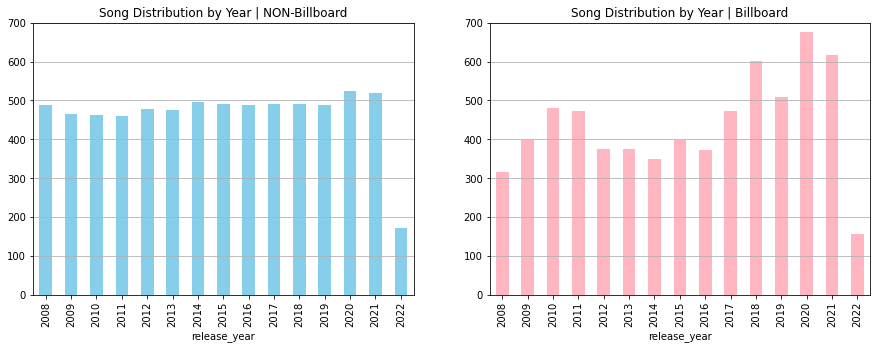

In [8]:
plt.subplots(1,2, figsize=(15,5))

plt.subplot(1,2,1)
nonbb_df[nonbb_df['release_year'] > 2007].groupby('release_year')['billboard'].count().plot(kind='bar', color='skyblue')
plt.grid(axis='y')
plt.ylim(top=700)
plt.title('Song Distribution by Year | NON-Billboard')

plt.subplot(1,2,2)
bb_df[bb_df['release_year'] > 2007].groupby('release_year')['billboard'].count().plot(kind='bar', color='lightpink')
plt.grid(axis='y')
plt.ylim(top=700)
plt.title('Song Distribution by Year | Billboard')

plt.show()

Not bad! Each year is represented fairly by both classes. 2022 is seeing a dip because our Billboard data stops at May 7, 2022.

---
### Data Transformation<a class="anchor" id="transform"></a>

We saw earlier that almost all the columns are in a string format. In prepartion for our models, we will convert non-numeric columns to numeric columns and also try to derive meaningful features from the data provided here (also called Feature Engineering).

#### Converting Non-numeric to Numeric<a class="anchor" id="numcols"></a>

Let's take a peak at a few rows to understand the structure and format of teh data.

In [10]:
songs_df.sample(3).T

,8977,5037,11739
billboard,1,1,1
billboard_year,2019,2022,2018
billboard_date,11/16/2019,3/12/2022,3/17/2018
peak_position,70,61,82
weeks_on_chart,2,10,4
artist,Miranda Lambert,Gunna,SZA
feat_artist,-,-,-
artist_uri,66lH4jAE7pqPlOlzUKbwA0,2hlmm7s2ICUX0LVIhVFlZQ,7tYKF4w9nC0nq9CsPZTHyP
artist_popularity,72,85,82
artist_followers,3210531,4352432,7910510


We will start with the most obvious columns first. The last several columns represent Spotify metrics which are measured in numerical form.

In [11]:
# look at the values within the spotify metric columns
songs_df['key'].unique()

array(['9', '3', '0', '6', '7', '11', '2', '1', '5', '10', '8', '4', '-',
       nan], dtype=object)

It looks like we have hypens '-' and null values (NaN) within this column. Let's place those values with zeros for all Spotify metrics columns.

In [12]:
# replace zeros for null/hypenated values in all spotify metrics columns
for column in songs_df.iloc[:,-13:].columns:
    songs_df.loc[songs_df[column] == '-', column] = 0
    songs_df[column] = songs_df[column].fillna(0)
    
# convert columns to numeric
songs_df['duration_ms'] = songs_df['duration_ms'].astype('int64')
songs_df['danceability'] = songs_df['danceability'].astype('float64')
songs_df['energy'] = songs_df['energy'].astype('float64')
songs_df['loudness'] = songs_df['loudness'].astype('float64')
songs_df['speechiness'] = songs_df['speechiness'].astype('float64')
songs_df['acousticness'] = songs_df['acousticness'].astype('float64')
songs_df['instrumentalness'] = songs_df['instrumentalness'].astype('float64')
songs_df['liveness'] = songs_df['liveness'].astype('float64')
songs_df['valence'] = songs_df['valence'].astype('float64')
songs_df['tempo'] = songs_df['tempo'].astype('float64')
songs_df['key'] = songs_df['key'].astype('int64')
songs_df['mode'] = songs_df['mode'].astype('int64')
songs_df['time_signature'] = songs_df['time_signature'].astype('int64')

In [13]:
# check the changes
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  object 
 2   billboard_date     13807 non-null  object 
 3   peak_position      13807 non-null  object 
 4   weeks_on_chart     13807 non-null  object 
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13804 non-null  object 
 8   artist_popularity  13804 non-null  object 
 9   artist_followers   13804 non-null  object 
 10  artist_genre       13777 non-null  object 
 11  song               13807 non-null  object 
 12  track_uri          13807 non-null  object 
 13  track_popularity   13807 non-null  object 
 14  album_name         13807 non-null  object 
 15  release_date       13807 non-null  object 
 16  release_year       138

Next, let's look at the date columns:
- We will convert `billboard_date` and `release_date` to datetime format.
- Then, we will extract the months as new features and drop the original date columns.
- Finally, we will convert the `billboard_year` column to integer.

In [14]:
# replace null or hypenated values with zeros
for column in ['billboard_year', 'billboard_date', 'release_date', 'release_year']:
    songs_df.loc[songs_df[column] == '-', column] = 0
    songs_df[column] = songs_df[column].fillna(0)
    
# convert to datetime and integers
songs_df['billboard_date'] = songs_df['billboard_date'].astype('datetime64')
songs_df['release_date'] = songs_df['release_date'].astype('datetime64')
songs_df['billboard_year'] = songs_df['billboard_year'].astype('int64')

# pull month and days from the dates
songs_df['billboard_month'] = pd.DatetimeIndex(songs_df['billboard_date']).month
songs_df['release_month'] = pd.DatetimeIndex(songs_df['release_date']).month

# replace billboard month as zero for non-billboard songs
songs_df.loc[songs_df['billboard'] == 0, 'billboard_month'] = 0

# drop the original date columns
songs_df = songs_df.drop(columns=['billboard_date','release_date'])

In [15]:
# check if new columns were created
songs_df.columns

Index(['billboard', 'billboard_year', 'peak_position', 'weeks_on_chart',
       'artist', 'feat_artist', 'artist_uri', 'artist_popularity',
       'artist_followers', 'artist_genre', 'song', 'track_uri',
       'track_popularity', 'album_name', 'release_year', 'duration_ms',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'billboard_month', 'release_month'],
      dtype='object')

In [16]:
# let's re-order the new features
songs_df = songs_df.reindex(columns=['billboard', 'billboard_year', 'billboard_month', 'peak_position', 'weeks_on_chart',
                                     'artist', 'feat_artist', 'artist_uri', 'artist_popularity', 'artist_followers',
                                     'artist_genre', 'song', 'track_uri', 'track_popularity', 'album_name', 'release_year',
                                     'release_month', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
                                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                     'time_signature'])

In [17]:
# check the changes
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  object 
 4   weeks_on_chart     13807 non-null  object 
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13804 non-null  object 
 8   artist_popularity  13804 non-null  object 
 9   artist_followers   13804 non-null  object 
 10  artist_genre       13777 non-null  object 
 11  song               13807 non-null  object 
 12  track_uri          13807 non-null  object 
 13  track_popularity   13807 non-null  object 
 14  album_name         13807 non-null  object 
 15  release_year       13807 non-null  int64  
 16  release_month      138

Next, let's look at the rest of the billboard stats: `peak_position` and `weeks_on_chart`. These columns should repesent integers. Like the previous columns, we will replace any hypens or null values and then convert the data type.

In [18]:
# replace null or empty values with zero
for column in ['peak_position', 'weeks_on_chart']:
    songs_df.loc[songs_df[column] == '-', column] = 0
    songs_df.loc[songs_df[column].isna(), column] = 0
    
# convert data type
songs_df['peak_position'] = songs_df['peak_position'].astype('int64')
songs_df['weeks_on_chart'] = songs_df['weeks_on_chart'].astype('int64')

In [19]:
# check the changes
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13804 non-null  object 
 8   artist_popularity  13804 non-null  object 
 9   artist_followers   13804 non-null  object 
 10  artist_genre       13777 non-null  object 
 11  song               13807 non-null  object 
 12  track_uri          13807 non-null  object 
 13  track_popularity   13807 non-null  object 
 14  album_name         13807 non-null  object 
 15  release_year       13807 non-null  int64  
 16  release_month      138

Now let's take a peek at a sample of the remaining non-numeric columns.

In [20]:
songs_df.loc[:, songs_df.dtypes == 'object'].sample(3)

,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri,track_popularity,album_name
309,Aaryan Shah,-,4RzbexUO843fc5SLqKEQCr,61,71253,trap soul,Dissociation,6E83K2PlNqMIEtiZQP6dAD,0,The Arrival: Part II
6027,Joe,-,3zTOe1BtyTkwNvYZOxXktX,63,1506720,"['contemporary r&b', 'dance pop', 'hip pop', '...",Worst Case Scenario,6IfvycE0Y1ftfpVN7exBW8,35,Signature
6650,Keith Urban,-,0u2FHSq3ln94y5Q57xazwf,69,4712242,"australian country, australian pop, contempora...",Female,1t34UsQ634a233qysq6D6L,52,Graffiti U


Much of this is text data which we want to separately vectorize and/or drop. We will convert `artist_popularity`, `artist_followers` and `track_popularity` to numbers.

In [21]:
# replace null or hypenated values with 0
for column in ['artist_popularity', 'artist_followers', 'track_popularity']:
    songs_df.loc[songs_df[column] == '-', column] = 0
    songs_df[column] = songs_df[column].fillna(0)

# convert to integers
songs_df['artist_popularity'] = songs_df['artist_popularity'].astype('int64')
songs_df['artist_followers'] = songs_df['artist_followers'].astype('int64')
songs_df['track_popularity'] = songs_df['track_popularity'].astype('int64')


In [22]:
# check the changes
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13804 non-null  object 
 8   artist_popularity  13807 non-null  int64  
 9   artist_followers   13807 non-null  int64  
 10  artist_genre       13777 non-null  object 
 11  song               13807 non-null  object 
 12  track_uri          13807 non-null  object 
 13  track_popularity   13807 non-null  int64  
 14  album_name         13807 non-null  object 
 15  release_year       13807 non-null  int64  
 16  release_month      138

#### Null Values and Duplicates<a class="anchor" id="nulldupe"></a>

In [23]:
# columns have some null values
songs_df.isna().sum()

billboard             0
billboard_year        0
billboard_month       0
peak_position         0
weeks_on_chart        0
artist                0
feat_artist           0
artist_uri            3
artist_popularity     0
artist_followers      0
artist_genre         30
song                  0
track_uri             0
track_popularity      0
album_name            0
release_year          0
release_month         0
duration_ms           0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
dtype: int64

Let's look at the null values under `artist_genre` and `artist_uri`.

In [24]:
# null values under artist_genre
songs_df.loc[songs_df['artist_genre'].isna(),:].sample(3)

,billboard,billboard_year,billboard_month,peak_position,weeks_on_chart,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri,track_popularity,album_name,release_year,release_month,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
12739,0,0,0,0,0,Train,-,NaN,0,0,NaN,Feels Good at First,1TYnyC8RLvMF9k6LKZi3pk,39,California 37,2012,4,182973,0.690,0.376,7,-7.023,1,0.0276,0.45600,0.00000,0.093,0.358,109.880,4
4047,0,0,0,0,0,ERIMAJ,-,47zB8HowGfion9FkA4xLYo,10,3225,NaN,Conflict Of A Man,7vBxSZNdN8gYFqCaNQ808v,0,Conflict Of A Man,2012,8,44794,0.566,0.675,6,-8.904,1,0.0322,0.00714,0.00338,0.143,0.369,93.893,4
3235,1,2022,1,27,14,Diane Guerrero,Stephanie Beatriz,18MFcGBHtyW0mU3ufcm0X1,67,4975,NaN,What Else Can I Do?,3XoYqtiWHhsk59frZupImG,77,Encanto (Original Motion Picture Soundtrack),2021,11,44866,0.718,0.709,4,-5.568,1,0.0390,0.25800,0.00000,0.101,0.540,119.974,4


Oftentimes, Spotify will not yet have genre-tagging for new or unknown artists. This column is not numeric, but we will replace the null values with a hyphen as a placeholder.

In [25]:
# replace null values with hyphens
songs_df.loc[songs_df['artist_genre'].isna(), 'artist_genre'] = '-'

In [26]:
# null values under artist_uri
songs_df.loc[songs_df['artist_uri'].isna(),:]

,billboard,billboard_year,billboard_month,peak_position,weeks_on_chart,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri,track_popularity,album_name,release_year,release_month,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
12739,0,0,0,0,0,Train,-,NaN,0,0,-,Feels Good at First,1TYnyC8RLvMF9k6LKZi3pk,39,California 37,2012,4,182973,0.690,0.376,7,-7.023,1,0.0276,0.45600,0.000000,0.093,0.358,109.880,4
12744,0,0,0,0,0,Train,-,NaN,0,0,-,Mermaid,2o3qA8lOCXZ8cRGhuWNT4J,52,California 37,2012,4,196933,0.720,0.883,8,-3.455,1,0.0398,0.01460,0.000000,0.102,0.921,104.008,4
12749,0,0,0,0,0,Train,-,NaN,0,0,-,This'll Be My Year,69iQM8CLaJFn8oqEefgPYw,42,California 37,2012,4,210053,0.655,0.797,2,-3.275,1,0.0574,0.00251,0.000056,0.313,0.633,121.828,4


Let's see if we have existing data on this artist:

In [27]:
songs_df.loc[songs_df['artist'] == 'Train',:].sample()

,billboard,billboard_year,billboard_month,peak_position,weeks_on_chart,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri,track_popularity,album_name,release_year,release_month,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
12736,1,2014,10,79,3,Train,-,3FUY2gzHeIiaesXtOAdB7A,71,4040998,"dance pop, neo mellow, pop, pop rock",Angel In Blue Jeans,2GxGYGrixbXPFojONbzdo9,55,Bulletproof Picasso,2014,9,44820,0.61,0.817,0,-4.775,1,0.0331,0.0151,0.000009,0.0998,0.688,115.036,4


Yes, we do! It looks like these cells were missed while acquiring data. Let's go ahead and impute them with the artist info.

In [28]:
songs_df.loc[songs_df['artist_uri'].isna(), 'artist_followers'] = 4038653
songs_df.loc[songs_df['artist_uri'].isna(), 'artist_genre'] = 'dance pop, neo mellow, pop, pop rock'
songs_df.loc[songs_df['artist_uri'].isna(), 'artist_popularity'] = 71
songs_df.loc[songs_df['artist_uri'].isna(), 'artist_uri'] = '3FUY2gzHeIiaesXtOAdB7A'

In [29]:
# check the changes
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13807 non-null  object 
 8   artist_popularity  13807 non-null  int64  
 9   artist_followers   13807 non-null  int64  
 10  artist_genre       13807 non-null  object 
 11  song               13807 non-null  object 
 12  track_uri          13807 non-null  object 
 13  track_popularity   13807 non-null  int64  
 14  album_name         13807 non-null  object 
 15  release_year       13807 non-null  int64  
 16  release_month      138

In [30]:
# now let's check the duplicates
songs_df.iloc[:,:13][songs_df.duplicated(subset=['track_uri', 'artist'], keep=False)]

,billboard,billboard_year,billboard_month,peak_position,weeks_on_chart,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri
3011,1,2008,6,58,1,David Archuleta,-,2C9n4tQgNLhHPhSCmdsQnk,53,480665,"dance pop, idol, lds youth, neo mellow, post-t...",Don't Let The Sun Go Down On Me,-
3012,1,2008,6,36,1,David Archuleta,-,2C9n4tQgNLhHPhSCmdsQnk,53,480665,"dance pop, idol, lds youth, neo mellow, post-t...",Imagine,-
3013,1,2008,6,60,1,David Archuleta,-,2C9n4tQgNLhHPhSCmdsQnk,53,480665,"dance pop, idol, lds youth, neo mellow, post-t...",In This Moment,-
3025,1,2008,6,67,1,David Cook,-,-,0,0,pop,Always Be My Baby,-
3026,1,2008,6,47,1,David Cook,-,-,0,0,pop,Billie Jean,-
3028,1,2008,6,15,2,David Cook,-,-,0,0,pop,Dream Big,-
3029,1,2008,6,92,1,David Cook,-,-,0,0,pop,Eleanor Rigby,-
3030,1,2008,6,73,1,David Cook,-,-,0,0,pop,Hello,-
3031,1,2008,6,42,1,David Cook,-,-,0,0,pop,I Don't Want To Miss A Thing,-
3032,1,2008,6,22,2,David Cook,-,-,0,0,pop,I Still Haven't Found What I'm Looking For,-


It looks like these are not true duplicates! The query thought two songs *without* `track_uri` were the same since the `subset` parameter was not looking at any other columns. The tracks with `track_uri` are "Enemy" by Imagine Dragons and "Oh Santa!" by Mariah Carey. But both these songs were listed on the Billboard during two separate times. We dont' want to lose that information, so we will keep all these songs.

---
## Feature Engineering

### New Feature: Classic vs. Emerging Artist<a class="anchor" id="majorlab"></a>

Based on research, we know that major label market share had been declining since 2017. We will use this information to create a new feature called `major_label`. Using 2016 as a threshold for "new and emerging artists", we will label any artist that released a song before 2016 as class 1, and any artist that gained attention or debuted their first song in 2016 or later as class 0. Essentially, we want to find the artists that are on the rise and stealing share from major labels.

In [31]:
songs_df['major_label'] = np.where(songs_df['release_year'] < 2016, 1, 0)

In [32]:
artist_df = songs_df[['artist_uri', 'artist', 'artist_popularity', 'artist_followers', 'artist_genre', 'major_label']]

In [33]:
print(f'Shape: {artist_df.shape}')
print(f"Duplicates: {artist_df['artist_uri'].duplicated().sum()}")
print(f"Unique Artists: {artist_df['artist_uri'].nunique()}")

Shape: (13807, 6)
Duplicates: 10616
Unique Artists: 3191


In [34]:
artist_df = artist_df.sort_values(by=['artist_uri', 'artist_followers'], ascending=False)

In [35]:
artist_df.head()

,artist_uri,artist,artist_popularity,artist_followers,artist_genre,major_label
10066,7zeHJIIfNStVfxlbT72UwY,Peter Murphy,43,184987,"['dark wave', 'gothic rock', 'new romantic', '...",1
5311,7za6M9P94wuMsOVCHopTsI,IAMDDB,50,384011,['uk contemporary r&b'],0
5312,7za6M9P94wuMsOVCHopTsI,IAMDDB,50,384011,['uk contemporary r&b'],0
8816,7zMVPOJPs5jgU8NorRxqJe,Michael Learns To Rock,60,1000491,"['boy band', 'danish pop rock']",1
8817,7zMVPOJPs5jgU8NorRxqJe,Michael Learns To Rock,60,1000491,"['boy band', 'danish pop rock']",1


In [36]:
# drop the duplicates since we don't need them
unique_artist_df = artist_df.drop_duplicates(subset=['artist_uri'], keep='first')

In [37]:
print(f'Shape: {unique_artist_df.shape}')
print(f"Duplicates: {unique_artist_df['artist_uri'].duplicated().sum()}")
print(f"Unique Artists: {unique_artist_df['artist_uri'].nunique()}")

Shape: (3191, 6)
Duplicates: 0
Unique Artists: 3191


In [38]:
for uri in unique_artist_df['artist_uri']:
    
    # update major_label
    major_label = (artist_df.loc[artist_df['artist_uri'] == uri, 'major_label']).max()
    unique_artist_df['major_label'][unique_artist_df['artist_uri'] == uri] = major_label

In [39]:
unique_artist_df['major_label'].value_counts()

1    1938
0    1253
Name: major_label, dtype: int64

We need to double check the class 0 category which may involve some Googling. Because this dataset is only a sample, some artists may not have appeared before 2016 by chance. We'll sort the artists by number of followers and look at the prominent ones. This could be a useful feature because of how the genres are attached to each artist. Perhaps our taste in music in changing? We'll analyze that in a bit.

In [40]:
unique_artist_df[unique_artist_df['major_label'] == 0].sort_values(by='artist_followers', ascending=False).head(10)

,artist_uri,artist,artist_popularity,artist_followers,artist_genre,major_label
1331,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,86,63888231,"['art pop', 'electropop', 'pop']",0
1978,3Nrfpe0tUJi4K4DXYWgMUX,BTS,92,50800538,"k-pop, k-pop boy group",0
994,4q3ewBCX7sLwd24euuV69X,Bad Bunny,100,49828511,"['latin', 'reggaeton', 'trap latino']",0
13454,15UsOTVnJzReFVN1VCnxy4,XXXTENTACION,87,36904893,"['emo rap', 'miami hip hop']",0
3665,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,88,34441936,"['dance pop', 'pop', 'uk pop']",0
5454,1vyhD5VmyZ7KMfW5gqLgo5,J Balvin,87,34219715,"['latin', 'reggaeton', 'reggaeton colombiano',...",0
9862,1i8SpTcr7yvPOmcqrbnVXY,Ozuna,85,32419974,"['latin', 'puerto rican pop', 'reggaeton', 'tr...",0
8366,1r4hJ1h58CWwUQe3MxPuau,Maluma,83,31227534,"latin, reggaeton, reggaeton colombiano, trap l...",0
1483,41MozSoPIsD1dJM0CLPjZF,BLACKPINK,78,30345478,"k-pop, k-pop girl group",0
2857,4VMYDCV2IEDYJArk749S6m,Daddy Yankee,87,27889123,"['latin', 'latin hip hop', 'reggaeton', 'trap ...",0


In [41]:
classic_artists = ['J Balvin', 'Alan Walker', 'Ozuna', 'Maluma', 'Daddy Yankee', 'Karol G', 'Juice WRLD', 'Nicky Jam',
                   'Farruko', 'Young Thug', 'Lil Baby', 'Zara Larsson', 'Elton John', 'Arcangel', 'Natti Natasha',
                   'Hailee Steinfeld', 'Reik', 'Aventura', 'Quavo', 'Frank Sinatra', 'Eric Clapton', 'Backstreet Boys',
                  'Metro Bloomin', 'Lauren Daigle', 'Lindsey Stirling', 'A$AP Mob']

for artist in unique_artist_df['artist']:
    if artist in classic_artists:
        unique_artist_df.loc[unique_artist_df['artist'] == artist, 'major_label'] = 1

In [42]:
unique_artist_df['major_label'].value_counts()

1    1958
0    1233
Name: major_label, dtype: int64

In [43]:
unique_artist_df.sample(3)

,artist_uri,artist,artist_popularity,artist_followers,artist_genre,major_label
10824,0ZrpamOxcZybMHGg1AYtHP,Robin Thicke,63,1866976,"['contemporary r&b', 'dance pop', 'hip pop', '...",1
1101,56ZTgzPBDge0OvCGgMO3OY,Beach House,70,1534394,"['baltimore indie', 'dream pop', 'dreamo', 'mo...",1
1324,7tQUtCKjvswULFCA0Em0GM,Bileo,29,3898,['rare groove'],1


In [44]:
# concatenate to main dataframe
songs_df['major_label'] = 0

In [45]:
for uri in unique_artist_df['artist_uri']:
    value = unique_artist_df['major_label'][unique_artist_df['artist_uri'] == uri].max()
    songs_df.loc[songs_df['artist_uri'] == uri, 'major_label'] = value

In [46]:
songs_df['major_label'].value_counts()

1    10804
0     3003
Name: major_label, dtype: int64

In [47]:
# we'll save this artist dataframe for separate analyses
unique_artist_df.to_csv('capstone_dataset_artists.csv')


---
### New Feature: Genre<a class="anchor" id="genre"></a>

Spotify has a lot of custom genres (currently over 5,000 and growing). In fact, this dataset alone has over 1000+. This is what is stated on their [website](https://artists.spotify.com/help/article/how-genre-charts-work):
> How are Spotify genres determined?
We define genres based on info from listener playlists (title, description, etc.) and our music curation teams. We don't use info from metadata or the playlist pitching tool in Spotify for Artists. We recognize genres constantly evolve and songs can cross different genres.

While this is extremely fascinating, we need to cluster these genres for dimensionality and interpretability purposes. This was an iterative process of moving Spotify genres to these clusters based on certain keywords.

In [48]:
# pull the genres into one list

genres = []

for genre in unique_artist_df['artist_genre']:
    genre = str(genre).lower()  # convert to string and make all lowercase    
    spec_char = ["[","'","]", "-"]
    
    for char in spec_char:
        genre = genre.replace(char,'')  # remove special characters
    genre = genre.split(', ')  # split into list

    for word in genre:
        genres.append(word)
        
genres = list(dict.fromkeys(genres)) # remove duplicates

# count to unique genres
print(f'There are {len(genres)} unique genres in this dataset.')

There are 1151 unique genres in this dataset.


In [49]:
# empty lists to store genres
pop = []
screen = []
hiphop = []
country = []
rnb = []
rock = []
latin = []
dance = []
indie = []
elect = []
blues = []
punk = []
gospel = []
chill = []

# keyword identifier
list_elect = ['elect', 'house', 'edm', 'techni', 'psych', 'trance', 'techno', 'tronica', 'step', 'bass', 'complextro',
             'ebm', 'aggrotech', 'russelater', 'vaporwave', 'breakbeat', 'glitch hop', 'trip hop', 'synth', 'grave wave',
             'big room', 'sky room', 'vapor twitch', 'hardstyle', 'rawstyle', 'new french touch', 'dark wave']
list_pop = ['pop', 'alt-z', 'idol', 'dream smp', 'alt z', 'opm', 'neo mellow', 'pagode baiano', 'lds youth', 'tvog',
           'slow game', 'musical advocacy', 'band', 'boy group', 'girl group']
list_screen = ['hollywood', 'disney', 'broadway', 'movie', 'glee club', 'children', 'soundtrack', 'idol', 'talent',
               'show tunes', 'dongyo', 'cartoon', 'halloween', 'novelty', 'anime', 'modern bollywood', 'filmi']
list_hiphop = ['hip hop', 'rap', 'chicago bop', 'drill', 'grime', 'crunk', 'plugg', 'futuristic swag', 'ambeat']
list_country = ['country', 'folk', 'cowboy', 'americana',  'banjo', 'modern oldtime', 'north carolina roots', 'oldtime',
               'nashville', 'modern uplift', 'red dirt', 'melancholia', 'redneck', 'lilith']
list_rnb = ['r&b', 'soul', 'afro', 'urban', 'motown', 'boogaloo']
list_rock = ['rock', 'metal', 'deathcore', 'hard', 'scream', 'jrock', 'grunge', 'prog', 'beatlesque', 'supergroup',
             'mellow gold', 'gymcore', 'double drumming', 'swancore', 'outsider', 'rogaland musikk', 'swedish melodeath',
            'thrash']
list_punk = ['punk', 'garage', 'permanent wave', 'band', 'industrial', 'easycore', 'emo', 'new wave']
list_latin = ['latin', 'reggaeton', 'mexi', 'espanol', 'salsa', 'dominicana', 'sertanejo', 'corridos', 'brasil', 'bachata',
             'champeta', 'sierreno', 'vallenato', 'corrido']
list_dance = ['dance', 'clubbing', 'disco', 'party', 'azonto', 'melbourne bounce', 'big beat', 'tropical', 'freestyle',
             'hands up']
list_indie = ['indie', 'alternative', 'singersongwriter', 'acoustic', 'solo wave', 'hopebeat', 'small room', 'korean ost',
             'jdivision']
list_gospel = ['worship', 'gospel', 'praise', 'ccm', 'christian']
list_blues = ['blues', 'funk', 'swing', 'groove', 'bluegrass', 'bossbeat', 'reggae']
list_chill = ['jazz', 'lounge', 'chillstep', 'chillwave', 'lofi', 'chillhop', 'saxophone', 'compositional ambient',
              'neoclassical', 'environmental','sleep', 'cello', 'middle earth', 'easy listening']

In [50]:
# for loop to identify Spotify genre's based on the keyword identifier above
for genre in unique_artist_df['artist_genre']:

    # convert string to all lowercase
    genre = str(genre).lower() 
    
    # remove special characters
    spec_char = ["[","'","]", "-"] 
    for char in spec_char:
        genre = genre.replace(char,'')
        
    # split into list
    genre = genre.split(', ')
    
    for word in genre:

        [elect.append(word) for x in list_elect if x in word]  
        [pop.append(word) for x in list_pop if x in word]
        [screen.append(word) for x in list_screen if x in word]
        [hiphop.append(word) for x in list_hiphop if x in word]
        [country.append(word) for x in list_country if x in word]
        [rnb.append(word) for x in list_rnb if x in word]
        [rock.append(word) for x in list_rock if x in word]
        [punk.append(word) for x in list_punk if x in word]
        [latin.append(word) for x in list_latin if x in word]
        [dance.append(word) for x in list_dance if x in word]
        [indie.append(word) for x in list_indie if x in word]
        [gospel.append(word) for x in list_gospel if x in word]
        [blues.append(word) for x in list_blues if x in word]
        [chill.append(word) for x in list_chill if x in word]

In [51]:
# add new genre columns with baseline zero values
unique_artist_df['genre_pop'], unique_artist_df['genre_screen'], unique_artist_df['genre_hiphop'], unique_artist_df['genre_punk'], unique_artist_df['genre_blues'], unique_artist_df['genre_country'], unique_artist_df['genre_rnb'], unique_artist_df['genre_rock'], unique_artist_df['genre_latin'], unique_artist_df['genre_dance'], unique_artist_df['genre_indie'], unique_artist_df['genre_elect'], unique_artist_df['genre_gospel'], unique_artist_df['genre_chill'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
# for loop to indicate "1" if artist falls within certain genre
for uri, genre in zip(unique_artist_df['artist_uri'], unique_artist_df['artist_genre']):
    
    genre = str(genre).lower()  # convert to string and make all lowercase
    
    spec_char = ["[","'","]", "-"]
    for char in spec_char:
        genre = genre.replace(char,'')  # remove special characters
        
    genre = genre.split(', ')  # split into list
    
    for word in genre:
        
        if word in screen:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_screen'] = 1
        if word in dance:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_dance'] = 1
        if word in country:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_country'] = 1
        if word in rnb:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_rnb'] = 1
        if word in hiphop:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_hiphop'] = 1        
        if word in rock:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_rock'] = 1
        if word in pop:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_pop'] = 1
        if word in latin:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_latin'] = 1
        if word in indie:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_indie'] = 1
        if word in elect:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_elect'] = 1
        if word in blues:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_blues'] = 1
        if word in punk:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_punk'] = 1
        if word in gospel:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_gospel'] = 1
        if word in chill:
            unique_artist_df.loc[unique_artist_df['artist_uri'] == uri, 'genre_chill'] = 1

In [53]:
# look at sample rows
unique_artist_df.sample(5)

,artist_uri,artist,artist_popularity,artist_followers,artist_genre,major_label,genre_pop,genre_screen,genre_hiphop,genre_punk,genre_blues,genre_country,genre_rnb,genre_rock,genre_latin,genre_dance,genre_indie,genre_elect,genre_gospel,genre_chill
1162,4AapPt7H6bGH4i7chTulpI,Ben Rector,61,317417,"acoustic pop, indiecoustica, lds youth, neo me...",1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
10985,20gsENnposVs2I4rQ5kvrf,Sam Feldt,72,694325,"['dance pop', 'edm', 'electro house', 'pop', '...",1,1,0,0,0,0,0,0,0,0,1,0,1,0,0
3826,0Y0QSi6lz1bPik5Ffjr8sd,Ekali,48,137418,"['canadian electronic', 'edm', 'electro house'...",0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
7384,5JZ7CnR6gTvEMKX4g70Amv,Lauv,77,5059110,"['dance pop', 'electropop', 'pop']",0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
12947,7n2Ycct7Beij7Dj7meI4X0,TWICE,79,13765617,"['k-pop', 'k-pop girl group']",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
# repeat the process on the main dataframe
songs_df['genre_pop'], songs_df['genre_screen'], songs_df['genre_hiphop'], songs_df['genre_punk'], songs_df['genre_blues'], songs_df['genre_country'], songs_df['genre_rnb'], songs_df['genre_rock'], songs_df['genre_latin'], songs_df['genre_dance'], songs_df['genre_indie'], songs_df['genre_elect'], songs_df['genre_gospel'], songs_df['genre_chill'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [55]:
# identify genre for each artist in songs_df by referencing unique_artist_df
for uri in unique_artist_df['artist_uri']:
    for i in unique_artist_df.columns[-15:]:
        value = unique_artist_df[i][unique_artist_df['artist_uri'] == uri].max()
        songs_df.loc[songs_df['artist_uri'] == uri, i] = value

In [56]:
# look at sample rows
songs_df.sample(5)

,billboard,billboard_year,billboard_month,peak_position,weeks_on_chart,artist,feat_artist,artist_uri,artist_popularity,artist_followers,artist_genre,song,track_uri,track_popularity,album_name,release_year,release_month,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,major_label,genre_pop,genre_screen,genre_hiphop,genre_punk,genre_blues,genre_country,genre_rnb,genre_rock,genre_latin,genre_dance,genre_indie,genre_elect,genre_gospel,genre_chill
10977,1,2020,10,4,34,SAINt JHN,-,0H39MdGGX6dbnnQPt6NQkZ,70,867889,"['melodic rap', 'pop rap', 'rap', 'slap house']",Roses,0zLCBJZSiELJf02ucPP9wb,69,While The World Was Burning,2020,11,176867,0.769,0.719,8,-5.472,1,0.0474,0.014300,0.007770,0.359,0.863,121.955,4,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
10957,0,0,0,0,0,Saba,-,7Hjbimq43OgxaBRpFXic4x,63,600737,"['alternative r&b', 'chicago rap', 'hip hop', ...",Photosynthesis,3DlgDXIYtnWtJKiB8bZQMv,66,Bucket List Project,2016,10,201732,0.777,0.662,7,-8.393,1,0.2700,0.536000,0.000005,0.593,0.634,111.130,4,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3462,0,0,0,0,0,Dove Cameron,-,57CDYxWdpuotIR3uY5QzPy,57,68313,"['post-teen pop', 'social media pop']",Better in Stereo,2eKYRRrNhXXr7SSzE3X99F,62,Disney Channel Play It Loud,2014,2,152573,0.699,0.827,0,-3.469,1,0.0372,0.222000,0.000000,0.350,0.819,109.971,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5188,1,2019,12,99,1,Harry Styles,-,6KImCVD70vtIoJWnq6nGn3,94,21352744,pop,She,6SQLk9HSNketfgs2AyIiMs,77,Fine Line,2019,12,44896,0.535,0.521,0,-5.942,1,0.0272,0.000532,0.371000,0.190,0.457,140.026,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
501,0,0,0,0,0,Alessia Cara,-,2wUjUUtkb5lvLKcGKsKqsR,73,10379113,"canadian contemporary r&b, canadian pop, dance...",Best Days,3z1DnGBH2uhlDekJr0YVzQ,64,In The Meantime,2021,9,211837,0.518,0.318,6,-11.727,1,0.0749,0.875000,0.000004,0.130,0.227,77.594,4,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0


In [57]:
# drop the original genre column and save dataframe
unique_artist_df = unique_artist_df.drop(columns='artist_genre')
unique_artist_df.to_csv('capstone_dataset_genre.csv', index=False)

In [58]:
# drop the original genre column and save dataframe
songs_df = songs_df.drop(columns='artist_genre')
songs_df = songs_df.to_csv('capstone_dataset_clean.csv', index=False)

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>